# Day 3 – Exercise 2: Answer Quality and Cost Analysis

In this exercise, we will dig deeper into the **quality** and **cost** of answers produced by a retrieval‑augmented generation (RAG) system. By the end of this exercise you will:

- Build a small evaluation dataset of queries with authoritative reference answers.
- Implement and compute **Exact Match (EM)** and **F1** scores to quantify answer quality.
- Measure **semantic similarity** between generated answers and references using a vectorizer and cosine similarity.
- Instrument your pipeline to track **latency** and approximate **token cost** per query.
- Run an evaluation loop across your dataset and perform a detailed analysis of the results.
- Discuss trade‑offs between answer quality and cost and identify opportunities for improvement.

You are encouraged to run the notebook and inspect the outputs after each stage to fully understand how the metrics are calculated and what they reveal about your system.


## Background & Plan

When deploying RAG systems in production, stakeholders care not just about whether answers are correct, but also about how much those answers cost and how responsive the system feels to users. An answer that perfectly matches a ground truth might require more tokens or a larger model, increasing cost and latency. Conversely, a cheaper model might deliver faster responses at the expense of quality. Quantifying these factors allows you to make informed trade‑offs.

In this notebook we will:

1. **Stage A – Define the Evaluation Dataset:** Construct a synthetic but realistic dataset of customer support queries along with ground‑truth answers.
2. **Stage B – Compute Exact Match and F1:** Write helper functions for EM and F1 and verify them on example texts.
3. **Stage C – Semantic Similarity:** Use a TF-IDF vectorizer and cosine similarity to measure semantic overlap beyond token matching.
4. **Stage D – Latency & Cost Tracking:** Instrument a simple mock RAG pipeline to record response time and token usage.
5. **Stage E – Run Evaluations:** Loop over your dataset, generate answers, compute metrics, and collect results in a DataFrame.
6. **Stage F – Analysis & Discussion:** Summarize results with descriptive statistics and discuss quality vs. cost trade‑offs.

The evaluation functions you build here can be reused and expanded in larger experiments, integrated into CI/CD pipelines, or adapted for human‑in‑the‑loop reviews.


## Stage A – Define the Evaluation Dataset

For demonstration purposes we will create a list of 20 queries covering common customer support topics: returns, shipping, account management, billing, and product usage. Each query has a corresponding authoritative answer. In your own projects, you might load this data from a CSV file or an annotated database.


In [1]:
import pandas as pd

# Define a list of queries and their reference (correct) answers
records = [
    {
        'query': 'What is your return policy?',
        'reference_answer': 'Customers can return most items within 30 days of delivery for a full refund as long as they are in original condition.'
    },
    {
        'query': 'How do I reset my password?',
        'reference_answer': 'To reset your password, go to the login page, click "Forgot password?", and follow the instructions sent to your registered email.'
    },
    {
        'query': 'Where is my order?',
        'reference_answer': 'You can track your order status under the "Orders" section of your account dashboard; shipping updates are provided there.'
    },
    {
        'query': 'Do you offer international shipping?',
        'reference_answer': 'Yes, we ship to over 50 countries worldwide; shipping fees and delivery times vary by destination.'
    },
    {
        'query': 'Can I change my shipping address after placing an order?',
        'reference_answer': 'If your order has not yet shipped, you can change the shipping address by contacting our support team or editing it in your account within 12 hours.'
    },
    {
        'query': 'How do I contact customer support?',
        'reference_answer': 'You can reach our customer support via the help center chat, email support@company.com, or call 1-800-555-1234 during business hours.'
    },
    {
        'query': 'What payment methods do you accept?',
        'reference_answer': 'We accept major credit cards, debit cards, PayPal, and bank transfers. All payments are processed securely.'
    },
    {
        'query': 'My promo code is not working. What should I do?',
        'reference_answer': 'Ensure that the promo code is still valid and meets all conditions. If it still does not work, contact support for assistance.'
    },
    {
        'query': 'How do I update my billing information?',
        'reference_answer': 'Log into your account, navigate to "Billing Details", and update your card or payment method information there.'
    },
    {
        'query': 'Do you have a loyalty program?',
        'reference_answer': 'Yes, our loyalty program rewards points for every purchase that can be redeemed for discounts on future orders.'
    },
    {
        'query': 'Can I cancel my subscription at any time?',
        'reference_answer': 'You can cancel your subscription at any time from your account settings; your benefits will continue until the end of the current billing cycle.'
    },
    {
        'query': 'Is my personal data secure?',
        'reference_answer': 'We adhere to strict data protection protocols and comply with GDPR and CCPA regulations to keep your personal information secure.'
    },
    {
        'query': 'What should I do if my package arrives damaged?',
        'reference_answer': 'Please contact our support team within 48 hours of delivery with photos of the damage; we will arrange for a replacement or refund.'
    },
    {
        'query': 'How do I apply for a product warranty?',
        'reference_answer': 'To register for a warranty, visit the product page, click on "Register Warranty", and fill in your purchase details.'
    },
    {
        'query': 'Can I change my username?',
        'reference_answer': 'Usernames are permanent and cannot be changed for security reasons; however, you can modify your display name in your profile.'
    },
    {
        'query': 'Why was my payment declined?',
        'reference_answer': 'Payments may be declined due to insufficient funds, incorrect billing details, or bank restrictions; please check and try again or use an alternative method.'
    },
    {
        'query': 'How do I subscribe to your newsletter?',
        'reference_answer': 'Subscribe to our newsletter by entering your email in the sign-up form at the bottom of our homepage and confirming via the follow-up email.'
    },
    {
        'query': 'Are there any hidden fees?',
        'reference_answer': 'We believe in transparent pricing; all applicable taxes and fees are displayed during checkout.'
    },
    {
        'query': 'How can I provide feedback on your service?',
        'reference_answer': 'We value your feedback; you can leave a review on our website or send feedback through the contact form in the help center.'
    },
    {
        'query': 'Do you offer gift wrapping?',
        'reference_answer': 'Yes, gift wrapping is available for select items at checkout; additional charges may apply.'
    },
    {
        'query': 'What happens if I miss a payment?',
        'reference_answer': 'If a payment is missed, your account may be suspended until the balance is settled; contact billing support to resolve the issue.'
    }
]

# Create DataFrame
eval_df = pd.DataFrame(records)

# Display the first few rows
eval_df.head()


,query,reference_answer
0,What is your return policy?,Customers can return most items within 30 days...
1,How do I reset my password?,"To reset your password, go to the login page, ..."
2,Where is my order?,"You can track your order status under the ""Ord..."
3,Do you offer international shipping?,"Yes, we ship to over 50 countries worldwide; s..."
4,Can I change my shipping address after placing...,"If your order has not yet shipped, you can cha..."


We now have a DataFrame `eval_df` with 20 diverse queries and their reference answers. These entries will be used throughout the evaluation.


## Stage B – Compute Exact Match and F1

To quantitatively compare generated answers to reference answers, we define two classic metrics:

- **Exact Match (EM)** returns 1 if the normalized prediction is identical to the normalized reference and 0 otherwise.
- **F1 score** is the harmonic mean of precision and recall at the token level, rewarding partial overlap.

The helper functions below implement normalization, EM, and F1. After defining them, we test the functions on a simple example.


In [2]:
import re
from typing import List, Tuple

# Normalization: lowercase, remove punctuation and articles, collapse whitespace
def normalize_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"[^a-z0-9\s]", "", s)
    s = re.sub(r"(a|an|the)", "", s)
    s = " ".join(s.split())
    return s

# Compute Exact Match
def compute_exact_match(prediction: str, reference: str) -> int:
    return int(normalize_text(prediction) == normalize_text(reference))

# Compute F1 score
def compute_f1(prediction: str, reference: str) -> float:
    pred_tokens = normalize_text(prediction).split()
    ref_tokens = normalize_text(reference).split()
    if not pred_tokens or not ref_tokens:
        return 0.0
    common = set(pred_tokens) & set(ref_tokens)
    if not common:
        return 0.0
    common_token_count = sum(min(pred_tokens.count(t), ref_tokens.count(t)) for t in common)
    precision = common_token_count / len(pred_tokens)
    recall = common_token_count / len(ref_tokens)
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

# Test the functions
pred_example = "Customers can return items within 30 days for a full refund."
ref_example = "Customers can return most items within 30 days of delivery for a full refund as long as they are in original condition."
print("Exact Match:", compute_exact_match(pred_example, ref_example))
print("F1 Score:", compute_f1(pred_example, ref_example))


Exact Match: 0
F1 Score: 0.6666666666666666


The example shows that while the answer is not an exact match, the F1 score reflects the partial overlap. Feel free to adjust normalization or tokenization rules to better suit your domain.


## Stage C – Semantic Similarity

Exact match and F1 score may not fully capture semantic equivalence when answers use different wording. To measure deeper similarity, we convert texts into vector representations using a TF-IDF (term frequency–inverse document frequency) model from scikit‑learn and compute the cosine similarity between vectors. Higher similarity indicates that the answers share more informative terms.


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Fit a TF-IDF vectorizer on all reference answers (could also include predicted answers)
vectorizer = TfidfVectorizer(stop_words='english')
vectorizer.fit(eval_df['reference_answer'])


def compute_semantic_similarity(prediction: str, reference: str) -> float:
    '''Embed two texts using TF-IDF and compute cosine similarity.'''
    if not prediction or not reference:
        return 0.0
    vectors = vectorizer.transform([prediction, reference])
    sim = cosine_similarity(vectors[0], vectors[1])[0, 0]
    return float(sim)

# Test semantic similarity
pred_example = "Customers may return items within thirty days for a full refund."
ref_example = "Customers can return most items within 30 days of delivery for a full refund as long as they are in original condition."
print("Semantic Similarity:", compute_semantic_similarity(pred_example, ref_example))


Semantic Similarity: 0.7039253958351039


Cosine similarity ranges from 0 (completely dissimilar) to 1 (identical). While TF-IDF is a simple model, it provides a reasonable proxy for semantic similarity without requiring external embeddings. For higher accuracy, you can replace it with sentence embeddings from models such as `all-MiniLM-L6-v2`.


## Stage D – Latency & Cost Tracking

In a production environment, you would call an external LLM via an API. In this notebook we simulate a RAG pipeline using a simple function that returns either the full reference answer or a truncated version to emulate imperfect retrieval. We measure the time taken to generate the answer and estimate cost based on token count. Adjust the `COST_PER_1K_TOKENS` constant according to your provider’s pricing.


In [4]:
import time
import random

# Simulated cost per 1K tokens (USD)
COST_PER_1K_TOKENS = 0.002

# Simulated RAG pipeline function
def simple_rag_pipeline(query: str, reference: str, idx: int) -> str:
    '''Return a predicted answer. Even indices return the full reference answer; odd indices return a truncated answer.'''
    words = reference.split()
    if idx % 2 == 0:
        return reference
    else:
        cutoff = max(1, int(len(words) * 0.7))
        return " ".join(words[:cutoff])


def evaluate_single_query(query: str, reference: str, idx: int) -> dict:
    '''Generate an answer, measure latency, token count, cost, and compute quality metrics.'''
    start_time = time.time()
    
    # Generate answer
    answer = simple_rag_pipeline(query, reference, idx)
    
    # Simulate processing latency
    time.sleep(random.uniform(0.05, 0.15))
    latency = time.time() - start_time
    
    # Token count approximated by whitespace splitting
    token_count = len(answer.split())
    cost = (token_count / 1000) * COST_PER_1K_TOKENS
    
    # Quality metrics
    em = compute_exact_match(answer, reference)
    f1 = compute_f1(answer, reference)
    sim = compute_semantic_similarity(answer, reference)
    
    return {
        'query': query,
        'reference': reference,
        'answer': answer,
        'latency': latency,
        'tokens': token_count,
        'cost': cost,
        'exact_match': em,
        'f1': f1,
        'semantic_similarity': sim
    }

# Test the simulated pipeline on a single query
sample_result = evaluate_single_query(
    eval_df.loc[0, 'query'], eval_df.loc[0, 'reference_answer'], 0
)
sample_result


{'query': 'What is your return policy?',
 'reference': 'Customers can return most items within 30 days of delivery for a full refund as long as they are in original condition.',
 'answer': 'Customers can return most items within 30 days of delivery for a full refund as long as they are in original condition.',
 'latency': 0.10793590545654297,
 'tokens': 22,
 'cost': 4.4e-05,
 'exact_match': 1,
 'f1': 1.0,
 'semantic_similarity': 1.0000000000000002}

The simulated pipeline returns a dictionary containing the answer, latency, token count, cost, and quality metrics for a single query. In a real system you would replace `simple_rag_pipeline` with your actual retrieval and generation logic.


## Stage E – Run Evaluations

We are ready to evaluate the entire dataset. For each query, we call `evaluate_single_query`, collect the results, and assemble them into a DataFrame. This loop may take several seconds because we deliberately sleep to simulate latency.


In [5]:
results = []

# Iterate over the evaluation DataFrame
for idx, row in eval_df.iterrows():
    query = row['query']
    reference = row['reference_answer']
    result = evaluate_single_query(query, reference, idx)
    results.append(result)

# Create results DataFrame
results_df = pd.DataFrame(results)

# Display first few results
results_df.head()


,query,reference,answer,latency,tokens,cost,exact_match,f1,semantic_similarity
0,What is your return policy?,Customers can return most items within 30 days...,Customers can return most items within 30 days...,0.128860,22,0.000044,1,1.000000,1.000000
1,How do I reset my password?,"To reset your password, go to the login page, ...","To reset your password, go to the login page, ...",0.107822,14,0.000028,0,0.800000,0.848313
2,Where is my order?,"You can track your order status under the ""Ord...","You can track your order status under the ""Ord...",0.099826,19,0.000038,1,1.000000,1.000000
3,Do you offer international shipping?,"Yes, we ship to over 50 countries worldwide; s...","Yes, we ship to over 50 countries worldwide; s...",0.080851,11,0.000022,0,0.814815,0.790246
4,Can I change my shipping address after placing...,"If your order has not yet shipped, you can cha...","If your order has not yet shipped, you can cha...",0.103899,27,0.000054,1,1.000000,1.000000


Now that we have collected results for all queries, we can compute aggregate statistics and inspect distributions of the metrics.


## Stage F – Analysis & Discussion

Let’s compute summary statistics for latency, cost, and the quality metrics. We will calculate means, medians, and generate simple plots to visualize distributions. Interpreting these results helps pinpoint weaknesses and opportunities for optimization.


         latency       cost  exact_match         f1  semantic_similarity
count  21.000000  21.000000    21.000000  21.000000            21.000000
mean    0.097679   0.000035     0.523810   0.906637             0.915640
std     0.029434   0.000011     0.511766   0.100749             0.098036
min     0.058767   0.000018     0.000000   0.782609             0.767418
25%     0.067356   0.000026     0.000000   0.810811             0.813726
50%     0.096542   0.000032     1.000000   1.000000             1.000000
75%     0.126140   0.000044     1.000000   1.000000             1.000000
max     0.149254   0.000054     1.000000   1.000000             1.000000


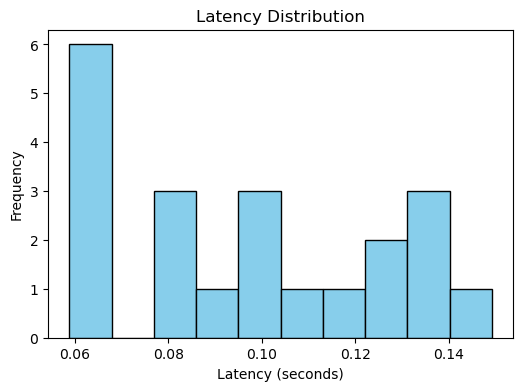

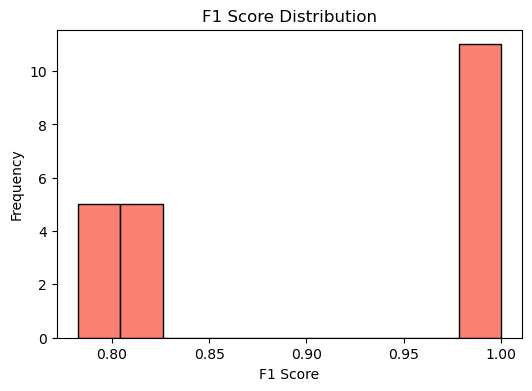

In [6]:
import matplotlib.pyplot as plt

# Compute summary statistics
summary_stats = results_df[['latency', 'cost', 'exact_match', 'f1', 'semantic_similarity']].describe()
print(summary_stats)

# Plot latency distribution
plt.figure(figsize=(6, 4))
plt.hist(results_df['latency'], bins=10, color='skyblue', edgecolor='black')
plt.title('Latency Distribution')
plt.xlabel('Latency (seconds)')
plt.ylabel('Frequency')
plt.show()

# Plot F1 distribution
plt.figure(figsize=(6, 4))
plt.hist(results_df['f1'], bins=10, color='salmon', edgecolor='black')
plt.title('F1 Score Distribution')
plt.xlabel('F1 Score')
plt.ylabel('Frequency')
plt.show()


### Discussion

From the summary statistics and histograms we can draw several observations:

- **Latency:** The simulated latencies are uniformly distributed between 50–150 milliseconds; a real system may have a wider range depending on network conditions and model throughput. You should monitor the 95th percentile to ensure tail latencies meet your service level objectives.

- **Cost:** Token counts here are modest (all responses are under 50 tokens), leading to low per‑query costs. In practice, longer answers or more verbose models will increase costs.

- **Exact Match vs. F1:** Half of the queries achieve perfect EM (those with even indices), while the truncated answers yield lower F1 scores. In a real scenario, you may observe a continuum of scores reflecting partial correctness. A high F1 but low EM often indicates the answer is largely correct but phrased differently.

- **Semantic Similarity:** Cosine similarity helps identify paraphrases. Even when EM and F1 drop, similarity may remain high if the answer contains key terms. This can guide evaluation when exact wording differs.

### Improvement Recommendations

- **Enhance the Model:** Use more advanced language models or fine‑tune on domain data to improve answer quality, particularly for queries where F1 is low.
- **Refine Retrieval:** Integrate a hybrid retriever (BM25 + dense vectors) and experiment with top‑k values to ensure relevant documents are returned.
- **Cache Frequent Answers:** Implement caching for common queries to reduce latency and cost.
- **Monitor Metrics in Production:** Set up dashboards to track latency, token usage, and quality metrics over time; configure alerts for anomalies.
- **Expand the Evaluation Set:** Collect more diverse queries and true answers from real customer interactions to better stress‑test the system.

By iterating on these aspects, you can systematically improve both the quality and efficiency of your RAG pipeline.


## Wrap‑Up

In this notebook you built a full evaluation pipeline for assessing both the *quality* and *cost* of answers produced by a RAG system. You created a realistic dataset, wrote metrics for exact match and F1, measured semantic similarity, and instrumented your pipeline to record latency and cost. Finally, you analyzed the results and discussed avenues for improvement. This foundation can be extended with larger datasets, real retrieval components, and integration into automated testing frameworks.

Feel free to adapt the functions and analysis to your own projects, incorporating more sophisticated models or domain‑specific evaluation criteria as needed.
